In [1]:
import pandas as pd 
import numpy as np
import math
import os
from dotenv import load_dotenv
from alpha_vantage.timeseries import TimeSeries
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#retorno diário e acumulado
#melhor e pior desempenho
#calculo de alpha e beta
#análise de drawdown maximo
#retorno anualizado
#volatilidade anualizada
#indice sharpe anualizado
#visualização - gráfico de linha dos retornos 
#grafico de barra de retornos anualizados
#grafico de barras da volatilidade anualizada
#gráficos de linha comparando portfolio simulado com SP500
#gráfico de disperção (Benchmark no eixo X e retornos diários no eixo Y, adicionar linha de regressão para visualizar relação usada no Beta)

In [3]:
#Carregando dados de Invesco, JP Morgan Chase e Lilly
load_dotenv()
api_key = os.getenv('ALPHA_VANTAGE_KEY')
ts = TimeSeries(key=api_key, output_format='pandas')
ivz, meta_data = ts.get_daily(symbol='IVZ', outputsize='full')
lly, meta_data = ts.get_daily(symbol='LLY', outputsize='full')
jpm, meta_data = ts.get_daily(symbol='JPM', outputsize='full')

In [4]:
#Tratamento de dados
c_ivz = pd.DataFrame(ivz['4. close'])
c_ivz.index = pd.to_datetime(c_ivz.index)
c_ivz = c_ivz.sort_index(ascending=True)

c_lly = pd.DataFrame(lly['4. close'])
c_lly.index = pd.to_datetime(c_lly.index)
c_lly = c_lly.sort_index(ascending=True)

c_jpm = pd.DataFrame(jpm['4. close'])
c_jpm.index = pd.to_datetime(c_jpm.index)
c_jpm = c_jpm.sort_index(ascending=True)


In [25]:
#Retonos acumulados
daily_return_ivz = c_ivz.pct_change()
daily_return_lly = c_lly.pct_change()
daily_return_jpm = c_jpm.pct_change()

cummulated_daily_return_ivz = (1 + daily_return_ivz).cumprod() - 1
cummulated_daily_return_lly = (1 + daily_return_lly).cumprod() - 1
cummulated_daily_return_jpm = (1 + daily_return_jpm).cumprod() - 1

cummulated_returns = pd.concat([cummulated_daily_return_lly, cummulated_daily_return_ivz, cummulated_daily_return_jpm], ignore_index=True, axis=1).dropna()
cummulated_returns = cummulated_returns.rename(columns={
    0: 'LLY',
    1: 'IVZ',
    2: 'JPM'
})
cummulated_returns = cummulated_returns.rename_axis('date')

print(cummulated_daily_return_ivz.tail())
print(cummulated_daily_return_jpm.tail())
print(cummulated_daily_return_lly.tail())

cummulated_returns


            4. close
date                
2025-07-22 -0.536127
2025-07-23 -0.531980
2025-07-24 -0.532198
2025-07-25 -0.523903
2025-07-28 -0.526959
            4. close
date                
2025-07-22  2.487674
2025-07-23  2.551460
2025-07-24  2.548947
2025-07-25  2.573719
2025-07-28  2.568933
             4. close
date                 
2025-07-22  10.293673
2025-07-23  10.620218
2025-07-24  10.715345
2025-07-25  10.820945
2025-07-28  10.749818


,LLY,IVZ,JPM
date,,,
1999-11-02,0.001891,-0.023139,0.001556
1999-11-03,0.045527,-0.023139,-0.013404
1999-11-04,0.107345,-0.027287,0.006702
1999-11-05,0.120000,-0.028596,0.032192
1999-11-08,0.094545,-0.028596,0.009813
...,...,...,...
2025-07-22,10.293673,-0.536127,2.487674
2025-07-23,10.620218,-0.531980,2.551460
2025-07-24,10.715345,-0.532198,2.548947


In [6]:
#Melhor e pior retorno
best_return_stock = pd.Series({
    'lly':cummulated_daily_return_lly['4. close'].iloc[-1],
    'jpm':cummulated_daily_return_jpm['4. close'].iloc[-1],
    'ivz':cummulated_daily_return_ivz['4. close'].iloc[-1],
})


print('Melhor desempenho acumulado:\n', best_return_stock.sort_values(ascending=False))
print('Pior desempenho acumulado:\n', best_return_stock.sort_values(ascending=True))

Melhor desempenho acumulado:
 lly    10.749818
jpm     2.568933
ivz    -0.526959
dtype: float64
Pior desempenho acumulado:
 ivz    -0.526959
jpm     2.568933
lly    10.749818
dtype: float64


In [7]:
#Puxando dados do benchmark
spy, meta_data = ts.get_daily(symbol='spy', outputsize='full')

c_spy = pd.DataFrame(spy['4. close'])
c_spy.index = pd.to_datetime(c_spy.index)
c_spy = c_spy.sort_index(ascending=True)

daily_return_spy = c_spy.pct_change()
    

In [8]:
#Tratamento de dados para calcular o beta
returns_spy = daily_return_spy['4. close']
returns_ivz = daily_return_ivz['4. close']
returns_jpm = daily_return_jpm['4. close']
returns_lly = daily_return_lly['4. close']

data_for_beta = pd.DataFrame({
    'spy_returns': returns_spy,
    'ivz_returns': returns_ivz,
    'jpm_returns': returns_jpm,
    'lly_returns': returns_lly
}).dropna()

matrix_covariance = data_for_beta.cov()

In [9]:
#Calculo do beta
covariance_spy_ivz = matrix_covariance.loc['spy_returns', 'ivz_returns']
covariance_spy_jpm = matrix_covariance.loc['spy_returns', 'jpm_returns']
covariance_spy_lly = matrix_covariance.loc['spy_returns', 'lly_returns']

variance_spy = data_for_beta['spy_returns'].var()

beta_ivz = covariance_spy_ivz/variance_spy
beta_jpm = covariance_spy_jpm/variance_spy
beta_lly = covariance_spy_lly/variance_spy

beta_ivz, beta_jpm, beta_lly

(1.608614818117611, 1.3666441411523733, 0.6768643401074437)

In [10]:
#Calculo do alpha
r_f = 0.05
r_f_daily = (1 + r_f) ** (1/252) - 1
mean_benchmark_returns = returns_spy.mean()
mean_ivz_returns = returns_ivz.mean()
mean_jpm_returns = returns_jpm.mean()
mean_lly_returns = returns_lly.mean()

expected_return_ivz = r_f_daily + beta_ivz * (mean_benchmark_returns - r_f_daily)
expected_return_jpm = r_f_daily + beta_jpm * (mean_benchmark_returns - r_f_daily)
expected_return_lly = r_f_daily + beta_lly * (mean_benchmark_returns - r_f_daily)

daily_alpha_ivz = mean_ivz_returns - expected_return_ivz
daily_alpha_jpm = mean_jpm_returns - expected_return_jpm
daily_alpha_lly = mean_lly_returns - expected_return_lly

annualized_alpha_ivz = (1 + daily_alpha_ivz) ** (252/1) -1
annualized_alpha_jpm = (1 + daily_alpha_jpm) ** (252/1) - 1
annualized_alpha_lly = (1 + daily_alpha_lly) ** (252/1) -1

print('alpha ivz', annualized_alpha_ivz*100)
print('alpha jpm', annualized_alpha_jpm*100)
print('alpha lly', annualized_alpha_lly*100)


alpha ivz -1.5321763077698836
alpha jpm 3.112118400311359
alpha lly 6.735624187164313


In [11]:
#drawdown

equity_curve_ivz = (1 + cummulated_daily_return_ivz.dropna())
equity_curve_jpm = (1 + cummulated_daily_return_jpm.dropna())
equity_curve_lly = (1 + cummulated_daily_return_lly.dropna())

running_max_ivz = equity_curve_ivz.expanding(min_periods=1).max()
running_max_jpm = equity_curve_jpm.expanding(min_periods=1).max()
running_max_lly = equity_curve_lly.expanding(min_periods=1).max()

drawdown_ivz = (equity_curve_ivz/running_max_ivz) - 1
drawdown_jpm = (equity_curve_jpm/running_max_jpm) - 1
drawdown_lly = (equity_curve_lly/running_max_lly) - 1

drawdown_max_ivz = drawdown_ivz.min()
drawdown_max_jpm = drawdown_jpm.min()
drawdown_max_lly = drawdown_lly.min()

print('maior drawdown de Invesco:', drawdown_max_ivz)
print('maior drawdown de JP Morgan Chase:', drawdown_max_jpm)
print('maior drawdown de Lilly:',drawdown_max_lly)



maior drawdown de Invesco: 4. close   -0.947036
dtype: float64
maior drawdown de JP Morgan Chase: 4. close   -0.843147
dtype: float64
maior drawdown de Lilly: 4. close   -0.74682
dtype: float64


In [12]:
#retorno anualizado

annualized_return_ivz = (1 + cummulated_daily_return_ivz.iloc[-1]) ** (252/len(cummulated_daily_return_ivz.dropna())) - 1
annualized_return_jpm = (1 + cummulated_daily_return_jpm.iloc[-1]) ** (252/len(cummulated_daily_return_jpm.dropna())) - 1
annualized_return_lly = (1 + cummulated_daily_return_lly.iloc[-1]) ** (252/len(cummulated_daily_return_lly.dropna())) - 1

annualized_returns = pd.concat([annualized_return_lly, annualized_return_ivz, annualized_return_jpm], ignore_index=True, axis=1).dropna()
annualized_returns = annualized_returns.rename(columns={
    0: 'LLY',
    1: 'IVZ',
    2: 'JPM'
})
annualized_returns = annualized_returns.rename_axis('date')

#Comparação com SP500
cummulated_daily_return_spy = (1 + daily_return_spy).cumprod() -1

annualized_return_spy = (1 + cummulated_daily_return_spy.iloc[-1]) ** (252/len(cummulated_daily_return_spy.dropna())) - 1

print('retorno anualizado Invesco:', annualized_return_ivz*100)
print('retorno anualizado JP Morgan Chase:', annualized_return_jpm*100)
print('retorno anualizado Lilly:', annualized_return_lly*100)
print('Retorno anualizado SP500:',annualized_return_spy*100)


retorno anualizado Invesco: 4. close   -2.87265
Name: 2025-07-28 00:00:00, dtype: float64
retorno anualizado JP Morgan Chase: 4. close    5.078572
Name: 2025-07-28 00:00:00, dtype: float64
retorno anualizado Lilly: 4. close    10.06868
Name: 2025-07-28 00:00:00, dtype: float64
Retorno anualizado SP500: 4. close    6.209405
Name: 2025-07-28 00:00:00, dtype: float64


In [13]:
#volatilidade anualizada

historic_volatility_ivz = np.std(daily_return_ivz)
historic_volatility_jpm = np.std(daily_return_jpm)
historic_volatility_lly = np.std(daily_return_lly)

window_size = 20
monthly_volatility_ivz = daily_return_ivz.rolling(window=window_size, min_periods=1).std()
monthly_volatility_jpm = daily_return_jpm.rolling(window=window_size, min_periods=1).std()
monthly_volatility_lly = daily_return_lly.rolling(window=window_size, min_periods=1).std()

annualized_volatility_ivz = historic_volatility_ivz * math.sqrt(252)
annualized_volatility_jpm = historic_volatility_jpm * math.sqrt(252)
annualized_volatility_lly = historic_volatility_lly * math.sqrt(252)

annualized_volatilities = pd.DataFrame({
    "IVZ": annualized_volatility_ivz,
    "JPM": annualized_volatility_jpm,
    "LLY": annualized_volatility_lly,
})

print('Volatilidade anualizada Invesco:', annualized_volatility_ivz*100)
print('Volatilidade anualizada JP Morgan:', annualized_volatility_jpm*100)
print('Volatlidade anualizada Lilly:', annualized_volatility_lly*100)

annualized_volatilities

Volatilidade anualizada Invesco: 4. close    46.092618
dtype: float64
Volatilidade anualizada JP Morgan: 4. close    37.7957
dtype: float64
Volatlidade anualizada Lilly: 4. close    27.742846
dtype: float64


c:\Users\Bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,IVZ,JPM,LLY
4. close,0.460926,0.377957,0.277428


In [14]:
#sharpe anualizado 

sharpe_ivz = (annualized_return_ivz - 0.05)/annualized_volatility_ivz
sharpe_jpm = (annualized_return_jpm - 0.05)/annualized_volatility_jpm
sharpe_lly = (annualized_return_lly - 0.05)/annualized_volatility_lly

print('sharpe ivz:',sharpe_ivz)
print('sharpe jpm:',sharpe_jpm)
print('sharpe lly:',sharpe_lly)

#simulando um fundo com as 3 ações e calculando o sharpe

combined_daily_returns = pd.DataFrame({
    'ivz': daily_return_ivz['4. close'],
    'jpm': daily_return_jpm['4. close'],
    'lly': daily_return_lly['4. close']
})

num_assets = len(combined_daily_returns.columns)
weights = np.array([1/num_assets] * num_assets)

covariance_portfolio_matrix = combined_daily_returns.cov()

variance_portfolio = np.dot(weights.T, np.dot(covariance_portfolio_matrix, weights))

#volatilidade é o o desvio padrão
#desvio padrão é a raiz quadrada da variância
#variância é o quadrado do desvio padrão
daily_volatility_portfolio = np.sqrt(variance_portfolio)

annualized_volatility_portfolio = (daily_volatility_portfolio) * np.sqrt(252/1)

daily_portfolio_returns = combined_daily_returns.dot(weights)
cummulated_daily_return_portfolio = (1 + daily_portfolio_returns).cumprod() -1
annualized_return_portfolio = (1 + cummulated_daily_return_portfolio.iloc[-1]) ** (252/len(daily_portfolio_returns.dropna())) -1

portfolio_sharpe = (annualized_return_portfolio - 0.05)/annualized_volatility_portfolio
portfolio_sharpe


sharpe ivz: 4. close   -0.170801
dtype: float64
sharpe jpm: 4. close    0.002079
dtype: float64
sharpe lly: 4. close    0.182702
dtype: float64


0.07554069694902435

In [28]:
#preparação de dados para gráfico

cummulated_returns = cummulated_returns.reset_index()

In [29]:
cummulated_returns_long = cummulated_returns.melt(id_vars="date")

cummulated_returns_long

,date,variable,value
0,1999-11-02,LLY,0.001891
1,1999-11-03,LLY,0.045527
2,1999-11-04,LLY,0.107345
3,1999-11-05,LLY,0.120000
4,1999-11-08,LLY,0.094545
...,...,...,...
19411,2025-07-22,JPM,2.487674
19412,2025-07-23,JPM,2.551460
19413,2025-07-24,JPM,2.548947
19414,2025-07-25,JPM,2.573719


Text(0, 0.5, 'Return/100')

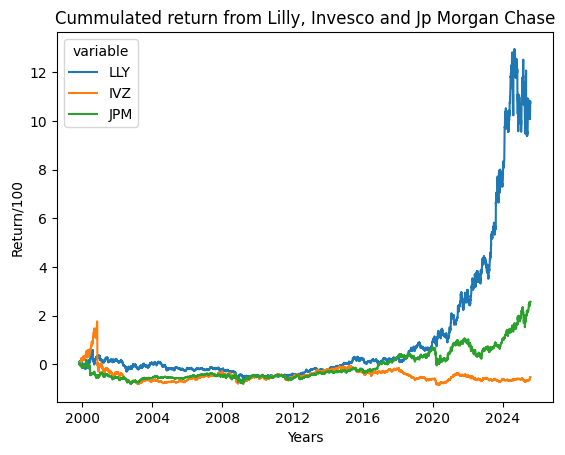

In [31]:
#gráfico de linhas de retornos acumulados
sns.lineplot(
    data=cummulated_returns_long,
    x= "date",
    y= "value",
    hue= "variable"
)

plt.title("Cummulated return from Lilly, Invesco and Jp Morgan Chase")
plt.xlabel("Years")
plt.ylabel("Return/100")

In [ ]:
#preparação de dados para gráfico de barras dos retornos anualizados
#usando transposição de matrizes
transposed_annualized_returns = annualized_returns.T
transposed_annualized_returns.reset_index()


date,index,4. close
0,LLY,0.100687
1,IVZ,-0.028726
2,JPM,0.050786


Text(0, 0.5, 'Return (%)')

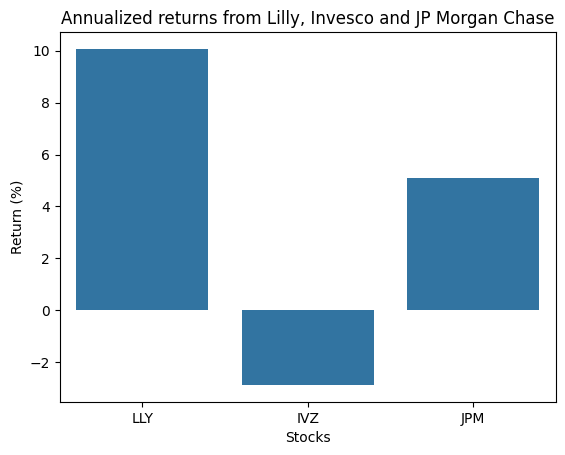

In [ ]:
#gráfico de barras dos retornos anualizados 
sns.barplot(transposed_annualized_returns*100, x=transposed_annualized_returns.index, y="4. close")
plt.title("Annualized returns from Lilly, Invesco and JP Morgan Chase")
plt.xlabel("Stocks")
plt.ylabel("Return (%)")

In [ ]:
#Transposição de matriz para construção do gráfico de barras
annualized_volatilities = annualized_volatilities.T

Text(0, 0.5, 'Annualized volatility (%)')

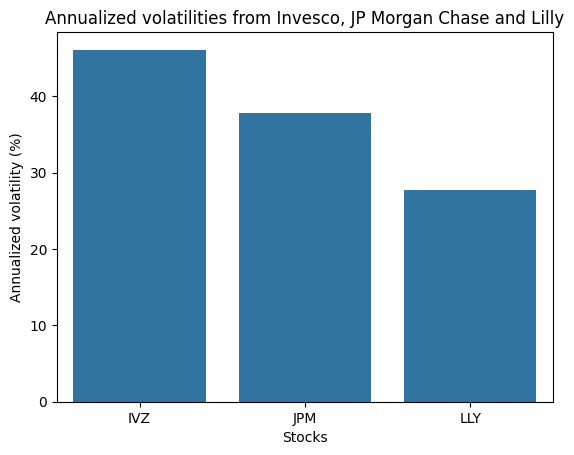

In [ ]:
#gráfico de barras da volatilidade anualizada
sns.barplot(annualized_volatilities*100, x=annualized_volatilities.index, y="4. close")

plt.title("Annualized volatilities from Invesco, JP Morgan Chase and Lilly")
plt.xlabel("Stocks")
plt.ylabel("Annualized volatility (%)")

In [ ]:
cummulated_daily_return_portfolio

date
1999-11-01         NaN
1999-11-02   -0.006564
1999-11-03    0.002913
1999-11-04    0.028072
1999-11-05    0.040204
                ...   
2025-07-22    4.822014
2025-07-23    4.930971
2025-07-24    4.944835
2025-07-25    5.011667
2025-07-28    4.984062
Length: 6473, dtype: float64

In [33]:
portfolio_spy = pd.concat([cummulated_daily_return_portfolio, cummulated_daily_return_spy], ignore_index=True, axis=1).dropna()
portfolio_spy = portfolio_spy.rename(columns={
    0: "Portfolio",
    1: "Spy"
})

portfolio_spy = portfolio_spy.reset_index()
portfolio_spy

,date,Portfolio,Spy
0,1999-11-02,-0.006564,-0.007147
1,1999-11-03,0.002913,-0.000461
2,1999-11-04,0.028072,0.007146
3,1999-11-05,0.040204,0.017059
4,1999-11-08,0.024806,0.017981
...,...,...,...
6467,2025-07-22,4.822014,3.638893
6468,2025-07-23,4.930971,3.678359
6469,2025-07-24,4.944835,3.679908
6470,2025-07-25,5.011667,3.699677


,date,variable,value
0,1999-11-02,Portfolio,-0.006564
1,1999-11-03,Portfolio,0.002913
2,1999-11-04,Portfolio,0.028072
3,1999-11-05,Portfolio,0.040204
4,1999-11-08,Portfolio,0.024806
...,...,...,...
12939,2025-07-22,Spy,3.638893
12940,2025-07-23,Spy,3.678359
12941,2025-07-24,Spy,3.679908
12942,2025-07-25,Spy,3.699677


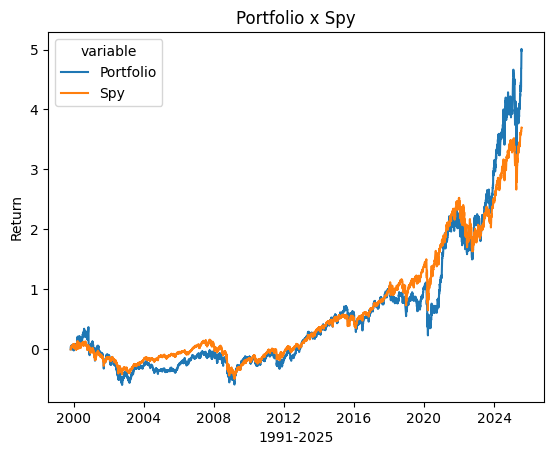

In [35]:
portfolio_spy_long = portfolio_spy.melt(id_vars="date", value_vars=["Portfolio", "Spy"], value_name="value")

sns.lineplot(portfolio_spy_long, x="date", y="value", hue="variable")
plt.title("Portfolio x Spy")
plt.xlabel("1991-2025")
plt.ylabel("Return")
portfolio_spy_long

Text(0, 0.5, 'IVZ returns')

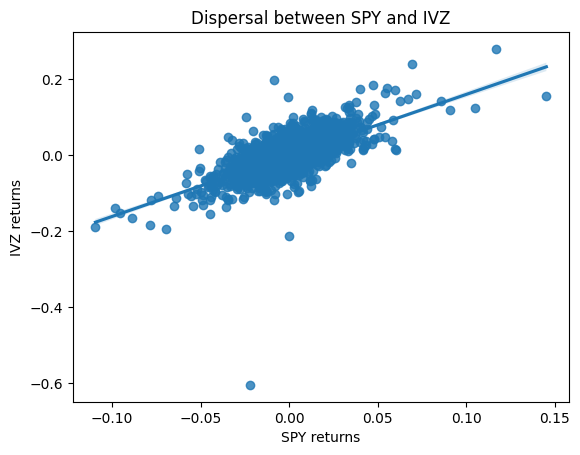

In [ ]:
#gráfico de dispersão benchmark x ivz
sns.regplot(data=data_for_beta, x="spy_returns", y="ivz_returns")
plt.title("Dispersal between SPY and IVZ")
plt.xlabel("SPY returns")
plt.ylabel("IVZ returns")




Text(0, 0.5, 'JPM returns')

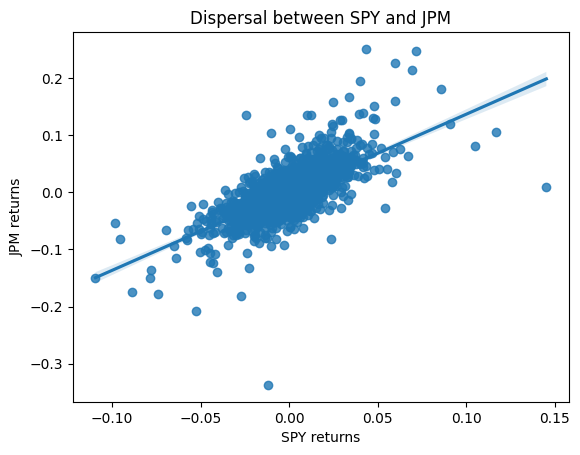

In [58]:
sns.regplot(data=data_for_beta, x="spy_returns", y="jpm_returns")
plt.title("Dispersal between SPY and JPM")
plt.xlabel("SPY returns")
plt.ylabel("JPM returns")

Text(0, 0.5, 'LLY returns')

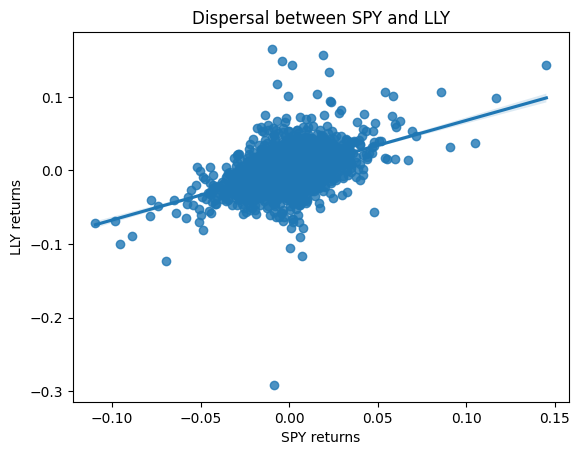

In [60]:
sns.regplot(data=data_for_beta, x="spy_returns", y="lly_returns")
plt.title("Dispersal between SPY and LLY")
plt.xlabel("SPY returns")
plt.ylabel("LLY returns")